In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score

In [2]:
def readData(filename,columns):
    df = pd.read_csv(filename,encoding='ISO-8859-1',usecols=columns)
    return df

In [3]:
def convertDataFrameToList(df_desc):
    doc = list()
    docList = df_desc['RISK DESCRIPTION'].str.split('\n')
    for i in range(len(docList)):
        doc.append(','.join(docList[i]))
    return doc

In [4]:
def computeTFIDF(docs):
    vectorizer = TfidfVectorizer(sublinear_tf=True)
    X = vectorizer.fit_transform(doc)
    return X.todense()

In [5]:
def encodeValues(encoder,df):
    df_encoded = pd.DataFrame()
    temp = pd.Series()
    
    df_encoded['ORT Level 1'] = encoder.fit_transform(df['ORT Level 1'])
    encoded_values = df_encoded['ORT Level 1'].unique()
    
    for element in encoded_values:
        temp = temp.append(pd.Series(encoder.fit_transform(df['ORT Level 2'].where(df_encoded['ORT Level 1'] == element).dropna())),ignore_index=True)
    
    df_encoded['ORT Level 2'] = temp
    
    return df_encoded

In [6]:
def createDictFunc(df,df_encoded):
    ORT_LEVEL_1_DICT = dict(zip(df['ORT Level 1'].unique(),df_encoded['ORT Level 1'].unique()))
    
    elements = df['ORT Level 2'].unique()
    indices = []
    
    for element in elements:
        indices.append(df[df['ORT Level 2'] == element].index[0])

    ORT_LEVEL_2_DICT = dict(zip(df['ORT Level 2'].unique(),df_encoded['ORT Level 2'].iloc[indices]))
    
    return ORT_LEVEL_1_DICT,ORT_LEVEL_2_DICT

In [7]:
def encoderFunc(df_data,level1_dict,level2_dict):
    df_data['ORT Level 1'] = df_data['ORT Level 1'].map(level1_dict)
    df_data['ORT Level 2'] = df_data['ORT Level 2'].map(level2_dict)
    return df_data

In [8]:
def splitData(df_data,label):
    X_train,X_test,Y_train,Y_test = train_test_split(df_data.drop(label,axis = 1),df_data[label], test_size = 0.2,random_state = 42,shuffle = True, stratify = df_data[label])
    return X_train,X_test,Y_train,Y_test

In [9]:
def classify(X_train,Y_train,classifier):
    classifier.fit(X_train,Y_train)
    return classifier

In [10]:
def computeAccuracy(X_test,Y_test,trained_classifier):
    accuracy = trained_classifier.score(X_test,Y_test) * 100
    return accuracy

In [11]:
df_desc = readData("D:/RiskProject/NewRiskDataFile.csv",['RISK DESCRIPTION'])
df_dataLevel = readData("D:/RiskProject/NewRiskDataFile.csv",['RISK DESCRIPTION','ORT LEVEL 1','ORT LEVEL 2'])
df_mapData = pd.read_excel("D:/RiskProject/RiskCategories.xlsx",usecols = ['ORT Level 1','ORT Level 2'],)

In [12]:
doc = convertDataFrameToList(df_desc)

In [13]:
df_data = pd.DataFrame(computeTFIDF(doc))

In [14]:
df_data['ORT Level 1'] = df_dataLevel['ORT LEVEL 1']
df_data['ORT Level 2'] = df_dataLevel['ORT LEVEL 2']

In [15]:
df_encoded = encodeValues(LabelEncoder(),df_mapData)

In [16]:
ORT_LEVEL_1_DICT,ORT_LEVEL_2_DICT = createDictFunc(df_mapData,df_encoded)

In [17]:
df_data = encoderFunc(df_data,ORT_LEVEL_1_DICT,ORT_LEVEL_2_DICT)

In [ ]:
gc.collect()

In [23]:
X_train,X_test,Y_train,Y_test = splitData(df_data.drop('ORT Level 2',axis = 1),'ORT Level 1')

In [24]:
MNBCLFL1 = classify(X_train,Y_train,MultinomialNB())

In [25]:
RFCCLFL1 = classify(X_train,Y_train,RandomForestClassifier())

In [26]:
RFCAccuracyLevel1 = computeAccuracy(X_test,Y_test,RFCCLFL1)

In [27]:
MNBAccuracyLevel1 = computeAccuracy(X_test,Y_test,MNBCLFL1)

In [28]:
print("Accuracy of RFC in predicting ORT LEVEL 1 RISK is: ",RFCAccuracyLevel1)

Accuracy of RFC in predicting ORT LEVEL 1 RISK is:  99.4055025577


In [29]:
print("Accuracy of MNB in predicting ORT LEVEL 1 RISK is: ",MNBAccuracyLevel1)

Accuracy of MNB in predicting ORT LEVEL 1 RISK is:  95.9214710355


# CODE TO CHECK PRECISION AND RECALL FOR ORT LEVEL 1

In [30]:
Y_predictRFCCLFL1 = RFCCLFL1.predict(X_test)
Y_predictMNBCLFL1 = MNBCLFL1.predict(X_test)

In [36]:
CLRPT = classification_report(Y_test,Y_predictRFCCLFL1)

In [69]:
import sklearn
sklearn.__version__

'0.19.1'

In [70]:
print("Classification report for RFCCLF1: \n", classification_report(Y_test,Y_predictRFCCLFL1))
print("Classification report for MNBCLF1: \n", classification_report(Y_test,Y_predictMNBCLFL1))

Classification report for RFCCLF1: 
              precision    recall  f1-score   support

          0       0.99      1.00      1.00      5411
          1       1.00      0.99      1.00       370
          2       0.99      0.98      0.99      1452

avg / total       0.99      0.99      0.99      7233

Classification report for MNBCLF1: 
              precision    recall  f1-score   support

          0       0.97      0.98      0.97      5411
          1       0.99      0.92      0.95       370
          2       0.93      0.89      0.91      1452

avg / total       0.96      0.96      0.96      7233



In [43]:
RFCCLFL1.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

# PRECISION_RECALL CURVE

In [74]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
from itertools import cycle

In [152]:
def plotPRCurve(X_train,X_test,Y_train,Y_test,clslst,model):
    Y_lb_train = label_binarize(Y_train,classes=clslst)
    Y_lb_test = label_binarize(Y_test,classes=clslst)
    n_classes = Y_lb_train.shape[1]
    classifier = OneVsRestClassifier(model)
    classifier.fit(X_train,Y_lb_train)
    Y_score = classifier.predict_proba(X_test)

    recall = dict()
    average_precision = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_lb_test[:, i],Y_score[:, i])
        average_precision[i] = average_precision_score(Y_lb_test[:, i], Y_score[:, i])

    precision["micro"], recall["micro"], _ = precision_recall_curve(Y_lb_test.ravel(),Y_score.ravel())    
    average_precision["micro"] = average_precision_score(Y_lb_test, Y_score,average="micro")

    plt.figure()
    plt.step(recall['micro'], precision['micro'], color='g', alpha=1,where='post')
    plt.fill_between(recall["micro"], precision["micro"], alpha=0.05, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('Average precision score, averaged over all classes: AP={0:0.2f}'.format(average_precision["micro"]))
    plt.show()
    
    for i in range(n_classes):
        l, = plt.plot(recall[i], precision[i], color='r', lw=2)
        lines.append(l)
        plt.xlim([0.0, 1.05])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall curve for class {0}'''.format(i))
        plt.show()

# Group the data by ORT Level 1

In [118]:
grouped_data = df_data.groupby('ORT Level 1')

In [119]:
df_data_0 = grouped_data.get_group(0)

In [120]:
df_data_1 = grouped_data.get_group(1)

In [121]:
df_data_2 = grouped_data.get_group(2)

In [122]:
import gc

In [123]:
gc.collect()

14585

# Classify ORT Level 2 for ORT Level 1 == 0

In [136]:
X_train_20,X_test_20,Y_train20,Y_test20 = splitData(df_data_0,'ORT Level 2')

In [138]:
RFCCLFL2 = classify(X_train_20,Y_train20,RandomForestClassifier())

In [131]:
lst = Y_train20.unique()

In [137]:
X_test_20[X_test_20.isnull().any(axis = 1)]

,0,1,2,3,4,5,6,7,8,9,...,5843,5844,5845,5846,5847,5848,5849,5850,5851,ORT Level 1


In [139]:
RFCAccuracyLevel2 = computeAccuracy(X_test_20,Y_test20,RFCCLFL2)

In [140]:
print("Accuracy of RFC in predicting ORT LEVEL 2 RISK for ORT LEVEL 1 Class 0 is: ",RFCAccuracyLevel2)

Accuracy of RFC in predicting ORT LEVEL 2 RISK for ORT LEVEL 1 Class 0 is:  98.2073553872


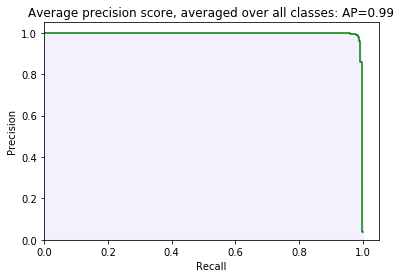

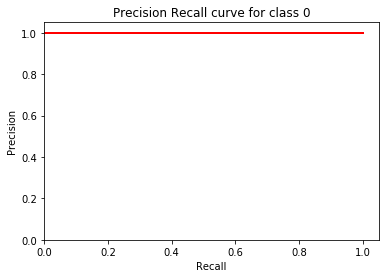

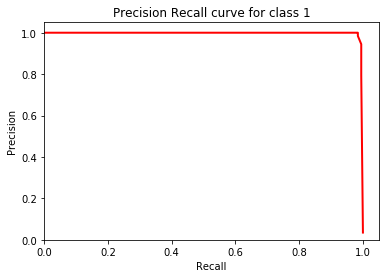

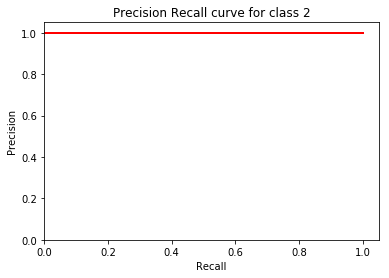

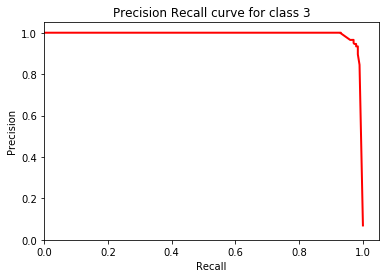

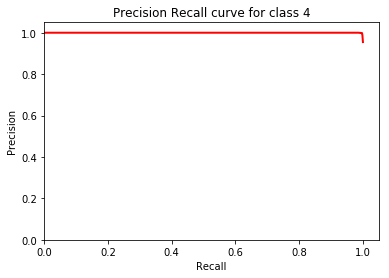

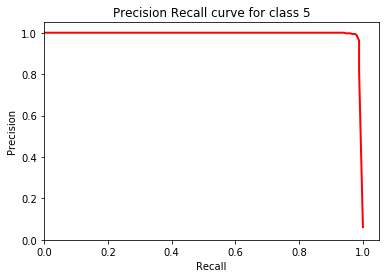

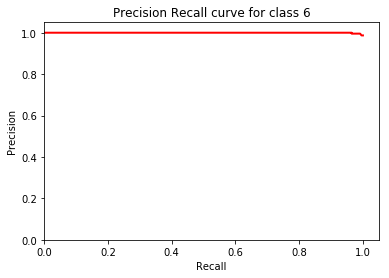

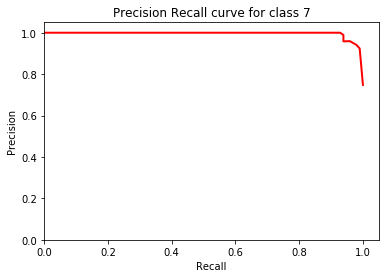

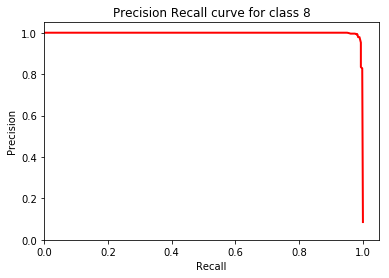

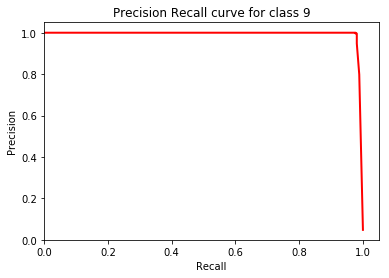

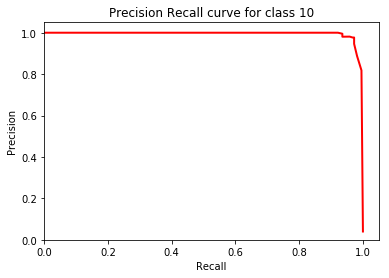

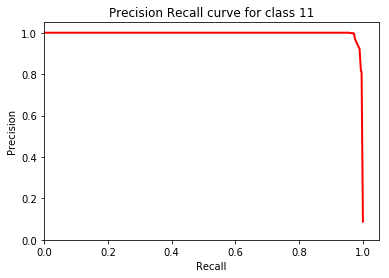

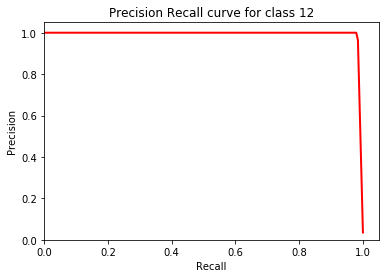

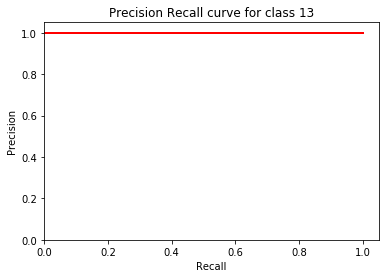

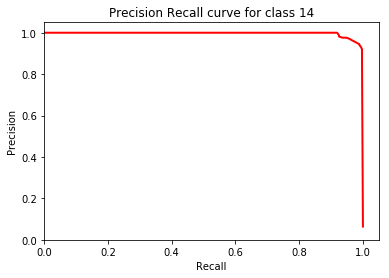

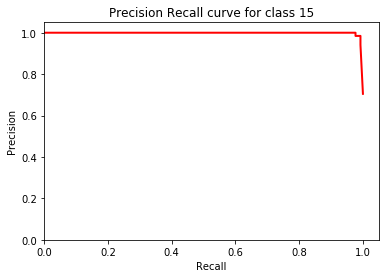

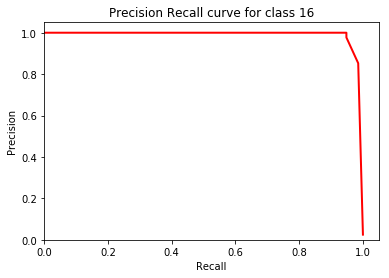

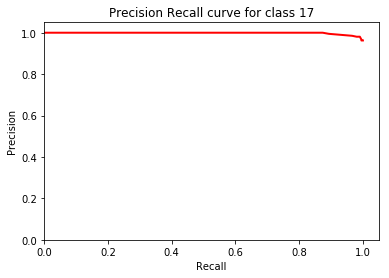

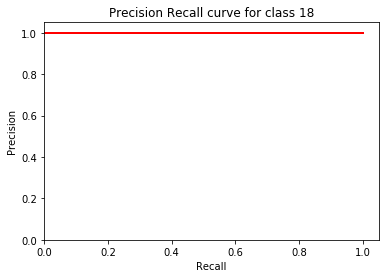

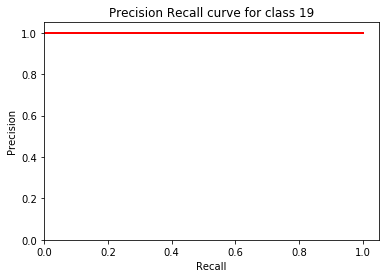

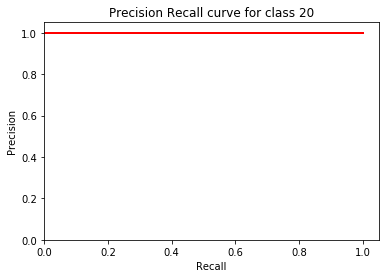

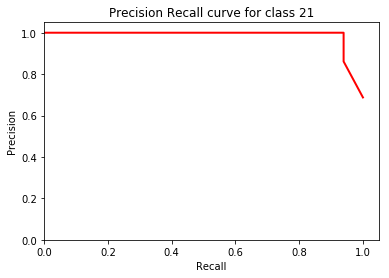

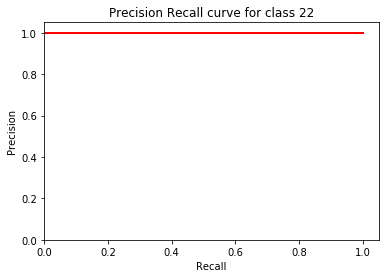

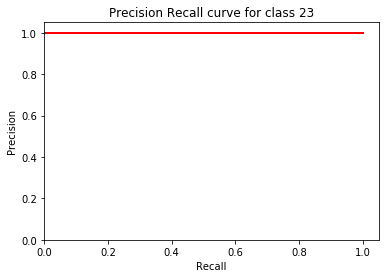

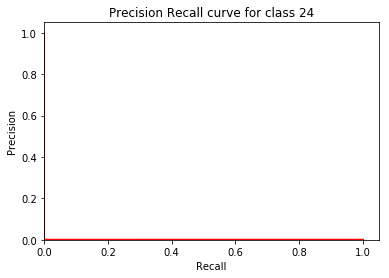

In [144]:
plotPRCurve(X_train_20,X_test_20,Y_train20,Y_test20,lst.tolist(),RFCCLFL2)

In [ ]:
Y_predictRFCCLFL2 = RFCCLFL2.predict(X_test_20)

In [ ]:
print("Classification report for Predicting ORT LEVEL 2 where ORT LEVEL 1 == 0: \n", classification_report(Y_test,Y_predictRFCCLFL2))

# Classify ORT Level 2 for ORT Level 1 == 1

In [145]:
X_train_21,X_test_21,Y_train21,Y_test21 = splitData(df_data_1,'ORT Level 2')

In [147]:
RFCCLFL2 = classify(X_train_21,Y_train21,RandomForestClassifier())

In [150]:
lst = Y_train21.unique()

In [148]:
RFCAccuracyLevel2 = computeAccuracy(X_test_21,Y_test21,RFCCLFL2)

In [149]:
print("Accuracy of RFC in predicting ORT LEVEL 2 RISK for ORT LEVEL 1 class 1 is: ",RFCAccuracyLevel2)

Accuracy of RFC in predicting ORT LEVEL 2 RISK for ORT LEVEL 1 class 1 is:  100.0


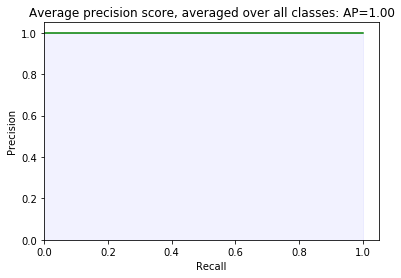

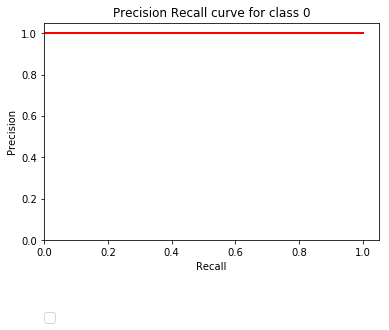

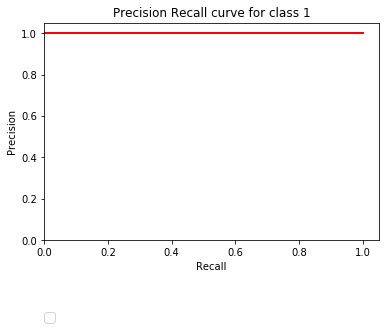

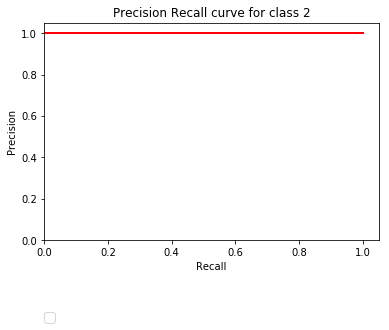

In [153]:
plotPRCurve(X_train_21,X_test_21,Y_train21,Y_test21,lst.tolist(),RFCCLFL2)

In [ ]:
Y_predictRFCCLFL2 = RFCCLFL2.predict(X_test)

In [ ]:
print("Classification report for Predicting ORT LEVEL 2 where ORT LEVEL 1 == 1: \n", classification_report(Y_test,Y_predictRFCCLFL2))

# Classify ORT Level 2 for ORT Level 1 == 2

In [154]:
X_train_22,X_test_22,Y_train22,Y_test22 = splitData(df_data_2,'ORT Level 2')

In [155]:
RFCCLFL2 = classify(X_train_22,Y_train22,RandomForestClassifier())

In [156]:
lst = Y_train22.unique()

In [157]:
RFCAccuracyLevel2 = computeAccuracy(X_test_22,Y_test22,RFCCLFL2)

In [158]:
print("Accuracy of RFC in predicting ORT LEVEL 2 RISK for ORT LEVEL 1 class 2 is: ",RFCAccuracyLevel2)

Accuracy of RFC in predicting ORT LEVEL 2 RISK for ORT LEVEL 1 class 2 is:  97.8650137741


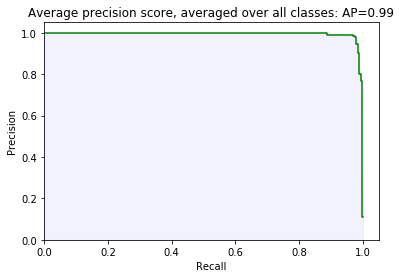

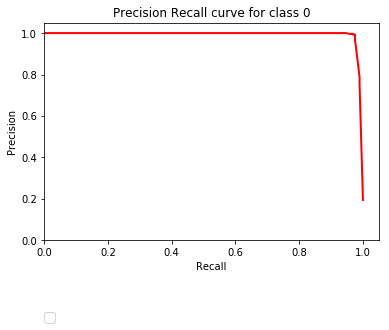

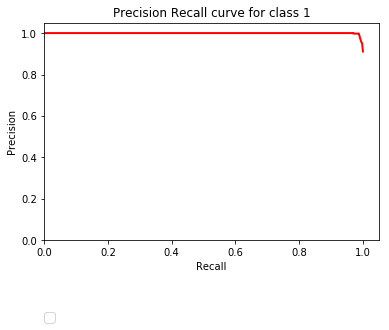

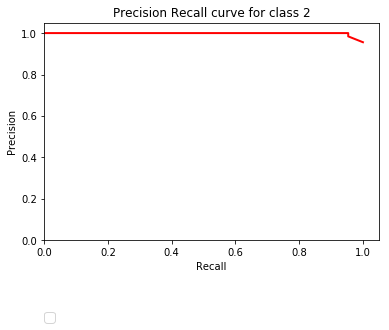

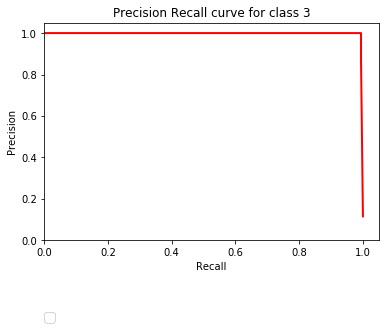

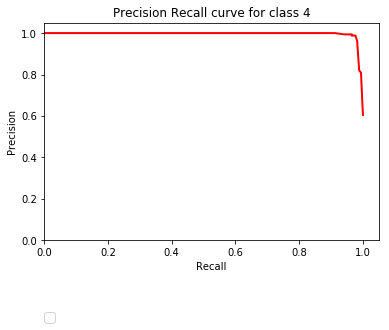

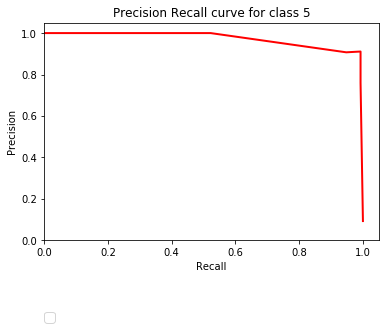

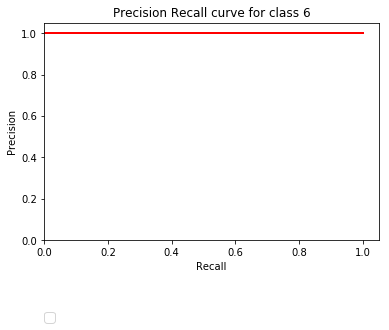

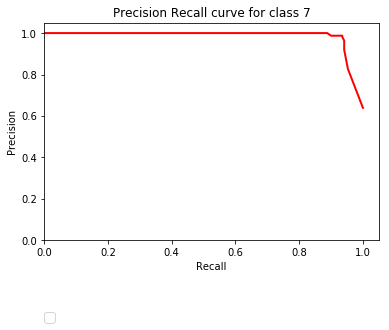

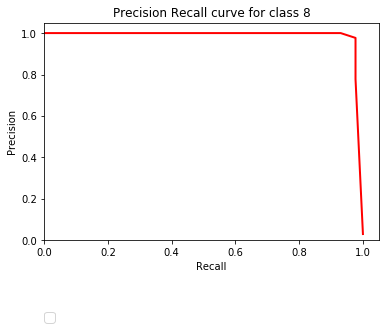

In [159]:
plotPRCurve(X_train_22,X_test_22,Y_train22,Y_test22,lst.tolist(),RFCCLFL2)

In [ ]:
Y_predictRFCCLFL2 = RFCCLFL2.predict(X_test)

In [ ]:
print("Classification report for Predicting ORT LEVEL 2 where ORT LEVEL 1 == 2: \n", classification_report(Y_test,Y_predictRFCCLFL2))